<a href="https://colab.research.google.com/github/ekkards/molecules/blob/master/LiH_trotter_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LiH molecule

## Origin of this method: Low rank decomposition of the Coulomb operator
 "Low rank representations for quantum simulation of electronic structure"
Mario Motta, Erika Ye, Jarrod R. McClean, Zhendong Li, Austin J. Minnich, Ryan Babbush, Garnet Kin-Lic Chan
https://arxiv.org/abs/1808.02625

The code is adapted from OpenFermion-Cirq Tutorial III: Low rank, arbitrary basis molecular simulations https://github.com/quantumlib/OpenFermion-Cirq/blob/master/examples/tutorial_3_arbitrary_basis_trotter.ipynb

In Tutorial III both of those techniques are combined, along with some insights from electronic structure,
to simulate a Trotter step under the arbitrary basis two-body operator as
$$
\prod_{\ell=0}^{L-1} R_\ell \exp\left(-i\sum_{pq} f_{\ell p} f_{\ell q} a^\dagger_p a_p a^\dagger_q a_q\right) R_\ell^\dagger
$$
where we note that the operator in the exponential take the form of a diagonal Coulomb operator. Since we can implement the $R_\ell$ circuits in $O(N)$ depth (see Tutorial I) and we can implement Trotter steps under diagonal Coulomb operators in $O(N)$ layers of gates (see Tutorial II) we see that we can implement Trotter steps under arbitrary basis electronic structure Hamiltionians in $O(L N) = O(N^2)$ depth, and all on a linearly connected device.

## Example implementation: Trotter steps of LiH in molecular orbital basis

We will now use these techniques to implement Trotter steps for an actual molecule. We will focus on LiH at equilibrium geometry, since integrals for that system are provided with every OpenFermion installation. However, by installing [OpenFermion-PySCF](https://github.com/quantumlib/OpenFermion-PySCF) or [OpenFermion-Psi4](https://github.com/quantumlib/OpenFermion-Psi4) one can use these techniques for any molecule at any geometry. We will generate LiH in an active space consisting of 4 qubits. First, we obtain the Hamiltonian as an InteractionOperator.

In [1]:
!pip install openfermion
import openfermion

# Set Hamiltonian parameters for LiH simulation in active space.
diatomic_bond_length = 1.45
geometry = [('Li', (0., 0., 0.)), ('H', (0., 0., diatomic_bond_length))]
basis = 'sto-3g'
multiplicity = 1
active_space_start = 1
active_space_stop = 3

# Generate and populate instance of MolecularData.
molecule = openfermion.MolecularData(geometry, basis, multiplicity, description="1.45")
molecule.load()

# Get the Hamiltonian in an active space.
molecular_hamiltonian = molecule.get_molecular_hamiltonian(
    occupied_indices=range(active_space_start),
    active_indices=range(active_space_start, active_space_stop))

print("Molecular Hamiltonian with 1 constant and {} 1-body and {} 2-body tensor terms"
        .format(molecular_hamiltonian.one_body_tensor.size, 
                molecular_hamiltonian.two_body_tensor.size))

# obtain the Hamiltonian as matrix
hamiltonian_sparse = openfermion.get_sparse_operator(molecular_hamiltonian)
LiH_matrix = hamiltonian_sparse.todense()
print("Hamiltonian matrix as {} from which {} are not null"
      .format( LiH_matrix.shape, hamiltonian_sparse.nnz))

# solve for eigenvalues by matrix algorithms
from scipy.linalg import eigh
eigenvalues , eigenvectors = eigh(LiH_matrix)
print("Eigenvalues  (Energies)\n", eigenvalues.round(6))
print("Eigenvectors (Orbitals)\n", eigenvectors.real.round(1))

     |████████████████████████████████| 634kB 4.9MB/s 
  Created wheel for openfermion: filename=openfermion-0.11.0-cp36-none-any.whl size=741938 sha256=4ebf0ddf066f81ed57c607ad5cdfa7388f0b8f92594549495f559e7ad3ce8fb4
  Stored in directory: /root/.cache/pip/wheels/83/78/92/3b9f9fdf47e6cd9d987fe83f48c7866abfb5e25df9cdbc5f0c
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-cp36-none-any.whl size=13825 sha256=c7375839b49c941bd0131d0bd69b57de9527df9a8cf972408b88b3f6960a3822
  Stored in directory: /root/.cache/pip/wheels/10/4d/51/6b843681a9a5aef35f0d0fbce243de46f85080036e16118752
Successfully built openfermion pubchempy
Molecular Hamiltonian with 1 constant and 16 1-body and 256 2-body tensor terms
Hamiltonian matrix as (16, 16) from which 36 are not null
Eigenvalues  (Energies)
 [-7.862773 -7.783396 -7.783396 -7.714057 -7.714057 -7.714057 -7.700476
 -7.569985 -7.569985 -7.512    -7.512    -7.364817 -7.151525 -7.130407
 -7.130407 -6.769813]
Eigenvectors (Orbitals)
 [[ 0.   0.   0.   

We are not yet aiming for chemical accuracy. We could check the Hamiltonian' eigenvalues with experimental data or compare to other computations from https://cccbdb.nist.gov/energy2.asp 
However, in the example the molecule integrals are provided by OpenFermion only for $1,45 \mathring{A}$. If you look up the experimental geometry (correct for the Born-Openheimer approximation), $r_{LiH} = 1.595 \mathring{A}$ for $^7Li$ https://cccbdb.nist.gov/expgeom2.asp.

You can see that the matrix calculation would result in exponential runtimes for larger systems. We convert the Hamiltonian for simulation with a quantum computer into the so-called "second quantized" operator form, as was shown in Tutorial II.
$$
H = \sum_{pq} T_{pq} a^\dagger_p a_q + \sum_{pq} V_{pq} a^\dagger_p a_p a^\dagger_q a_q.
$$

In [2]:
fermion_operator = openfermion.get_fermion_operator(molecular_hamiltonian)
print("Fermionic Hamiltonian with {} terms".format( len(fermion_operator.terms)))
#print(fermion_operator)

Fermionic Hamiltonian with 73 terms


We see from the above output that this is a fairly complex Hamiltonian already. Next we will use the `simulate_trotter` function from Tutorial I, but this time with the built-in `LOW_RANK` Trotter step type, associated with these low rank techniques.

Next we setup the simulation environment with qubits on a line.

In [3]:
!pip install cirq
!pip install openfermioncirq
import cirq
import openfermioncirq
from openfermioncirq import trotter

# Trotter step parameters.
time = 1.
final_rank = 2

# Initialize circuit qubits in a line.
n_qubits = openfermion.count_qubits(molecular_hamiltonian)
qubits = cirq.LineQubit.range(n_qubits)

     |████████████████████████████████| 1.4MB 4.7MB/s 
     |████████████████████████████████| 1.2MB 25.2MB/s 
  Found existing installation: protobuf 3.10.0
    Uninstalling protobuf-3.10.0:
      Successfully uninstalled protobuf-3.10.0


     |████████████████████████████████| 143kB 5.2MB/s 


In the cell below, we compile the Trotter step with full rank so $L = N^2$ and depth is actually $O(N^3)$ and repeat the Trotter step multiple times to show that it actually converges to the correct result. Note that the rank of the Coulomb operators is asymptotically $O(N)$ but for very small molecules in small basis sets only a few eigenvalues can be truncated.

In [4]:
# Initialize a random initial state.
import numpy
random_seed = 8317
initial_state = openfermion.haar_random_vector(
    2 ** n_qubits, random_seed).astype(numpy.complex64)

# Trotter step paramaters.
n_steps = 3

# Compile the low rank Trotter step using OpenFermion-Cirq.
qubits = cirq.LineQubit.range(n_qubits)
circuit = cirq.Circuit(
    trotter.simulate_trotter(
            qubits, molecular_hamiltonian,
            time=time, n_steps=n_steps,
            algorithm=trotter.LOW_RANK),
    strategy=cirq.InsertStrategy.EARLIEST)

# Print circuit.
print(f'Circuit was generated with {len(circuit)} moments')
cirq.DropNegligible().optimize_circuit(circuit)
cirq.DropEmptyMoments().optimize_circuit(circuit)
print(f'After optimization, Circuit has {len(circuit)} moments')
#print(circuit.to_text_diagram(transpose=True))

Circuit was generated with 178 moments
After optimization, Circuit has 169 moments


For comparison we compute the time step with the exact time evolution operator $\psi(t) = e^{ -i H t } \psi(0)$ in matrix form.

We plot the exact values as solid lines and the simulation as dashed lines and include a global phase $e^{i\pi/2}$ for each trotter step.

In [5]:
# Numerically compute the correct circuit output.
import scipy
exact_state = scipy.sparse.linalg.expm_multiply(
    -1j * time * hamiltonian_sparse, initial_state)

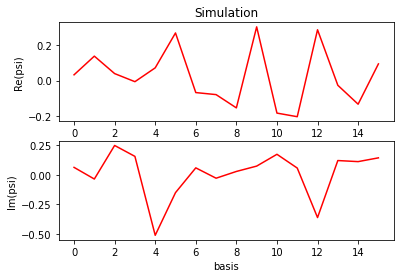

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import math, cmath
fig, axs = plt.subplots(2)
axs[1].set_xlabel('basis')
axs[0].set_ylabel('Re(psi)')
axs[1].set_ylabel('Im(psi)')
axs[0].set_title('Simulation')
x = range(exact_state.size)
phase = cmath.exp(1j*math.pi/2)
axs[0].plot(x, (phase*exact_state).real, 'r')
axs[1].plot(x, (phase*exact_state).imag, 'r')
plt.show();

Compare to complex conjugate state, why?
And why are Re and Im exchanged between exact and simulated?
Looks as if a phase factor is there...

In [ ]:
# Use Cirq simulator to apply circuit.
simulator = cirq.Simulator()
result = simulator.simulate(circuit, qubit_order=qubits, initial_state=initial_state)
simulated_state = result.final_state
#print( result )
axs[0].plot(x, simulated_state.real, 'r', dashes=[1, 1])
axs[1].plot(x, simulated_state.imag, 'r', dashes=[1, 1])

# Print final fidelity.
fidelity = abs(numpy.dot(simulated_state, numpy.conjugate(exact_state))) ** 2
print('Fidelity with exact result is {}.\n'.format(round(fidelity, 6)))


Fidelity with exact result is 0.999996.



In [ ]:
# Compute next time step
exact_state = scipy.sparse.linalg.expm_multiply(
    -1j * time * hamiltonian_sparse, exact_state)
phase *= cmath.exp(1j*math.pi/2)
axs[0].plot(x, (phase*exact_state).real, 'g')
axs[1].plot(x, (phase*exact_state).imag, 'g')
result = simulator.simulate(circuit, qubit_order=qubits, initial_state=simulated_state)
simulated_state = result.final_state
axs[0].plot(x, simulated_state.real, 'g', dashes=[1, 1])
axs[1].plot(x, simulated_state.imag, 'g', dashes=[1, 1])
fidelity = abs(numpy.dot(simulated_state, numpy.conjugate(exact_state))) ** 2
print('Fidelity with exact result is {}.\n'.format(round(fidelity, 6)))

Fidelity with exact result is 0.999985.



In [ ]:
# Compute time step 3
exact_state = scipy.sparse.linalg.expm_multiply(
    -1j * time * hamiltonian_sparse, exact_state)
phase *= cmath.exp(1j*math.pi/2)
axs[0].plot(x, (phase*exact_state).real, 'b')
axs[1].plot(x, (phase*exact_state).imag, 'b')
result = simulator.simulate(circuit, qubit_order=qubits, initial_state=simulated_state)
simulated_state = result.final_state
axs[0].plot(x, simulated_state.real, 'b', dashes=[1, 1])
axs[1].plot(x, simulated_state.imag, 'b', dashes=[1, 1])
fidelity = abs(numpy.dot(simulated_state, numpy.conjugate(exact_state))) ** 2
print('Fidelity with exact result is {}.\n'.format(round(fidelity, 6)))

Fidelity with exact result is 0.999969.



In [ ]:
# Compute time step 4
exact_state = scipy.sparse.linalg.expm_multiply(
    -1j * time * hamiltonian_sparse, exact_state)
phase *= cmath.exp(1j*math.pi/2)
axs[0].plot(x, (phase*exact_state).real, 'y')
axs[1].plot(x, (phase*exact_state).imag, 'y')
result = simulator.simulate(circuit, qubit_order=qubits, initial_state=simulated_state)
simulated_state = result.final_state
axs[0].plot(x, simulated_state.real, 'y', dashes=[1, 1])
axs[1].plot(x, simulated_state.imag, 'y', dashes=[1, 1])
fidelity = abs(numpy.dot(simulated_state, numpy.conjugate(exact_state))) ** 2
print('Fidelity with exact result is {}.\n'.format(round(fidelity, 6)))

Fidelity with exact result is 0.999949.



In [ ]:
for i, step in enumerate(simulator.simulate_moment_steps(circuit)):
    if i == 0:
        step.set_state_vector(simulated_state)
    else:
        color = (float(i/len(circuit)), float(i/len(circuit)), float(i/len(circuit))) 
        #print('state at step %d: %s' % (i, numpy.around(step.state_vector(), 3)))
        #axs[2].plot(x, numpy.real(step.state_vector()), color)
        #axs[3].plot(x, numpy.imag(step.state_vector()), color)
plt.show()